## EDA - IOT-23 34-1 Mirai

Este notebook faz parte do projeto avaliativo da disciplina de Tópicos Computacionais em Ciência de Dados. O intuito deste notebook é realizar um EDA dos dados do **IoT-23**. Dentre os diversos cenários que foram capturados se optou por fazer a análises do: **CTU-IoT-Malware-Capture-34-1 (Mirai)**.

### Sumário
1. Importações e Funções
2. Leitura dos dados
3. Transformações
4. Sanity
5. Análises Exploratórias

**Desenvolvido por**
- Yago Aquino
- yagopacheco.34@gmail.com

## 1. Importações e Funções

Nesta seção vamos realizar a importações das bibliotecas e funções usadas ao longo do EDA.

In [ ]:
import os
import re
import warnings

import numpy as np
import pandas as pd

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

from scipy.stats import chi2_contingency

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.6f}'.format)
warnings.filterwarnings('ignore')

# Se for rodar local no jupyter ou vsco
# import plotly.io as pio
# import plotly.offline as pyo
# pio.renderers.default = "notebook"
# pyo.init_notebook_mode(connected=True)

### 1.1 Funções

In [ ]:
def avalia_valores_nulos(df, tamanho_df):
    new_df = df.isna().sum().to_frame().rename(columns={0: 'QTD_NULOS'})
    new_df['%_NULOS'] = round(new_df['QTD_NULOS'] / tamanho_df * 100, 2)
    new_df = new_df[new_df['%_NULOS'] > 0].sort_values('%_NULOS', )

    return new_df


def qtd_unicos_coluna(df, col, top_5=False):
    '''
    Função para pegar a quantidade de cada
    valor único em uma coluna.
    '''
    contagem = df[col].value_counts()
    id_mais_frequente = contagem.index[0]
    frequencia = contagem.iloc[0]

    if top_5:
        return contagem.head()
    else:
        return f"O ID que mais se repete é {id_mais_frequente}, aparecendo {frequencia} vezes."


def avalia_valores_distintos(df, tamanho_df):
    distinct_counts = df.nunique().to_frame().rename(columns={0: 'QTD_DISTINTOS'})
    distinct_counts['%_DISTINTOS'] = round(distinct_counts['QTD_DISTINTOS'] / tamanho_df * 100, 2)
    distinct_counts = distinct_counts.sort_values('%_DISTINTOS', ascending=False)

    return distinct_counts


def obter_tab_freq(df, coluna, total=15):
  '''
  Função para obter a tabela de frequencia de uma coluna.
  '''
  # print("Tabela de frequencias")
  tam_df = df.shape[0]

  df = df[coluna].value_counts().to_frame().reset_index()
  df.columns = [coluna,'freq_absoluta']
  df['freq_relativa'] = round((df['freq_absoluta']/tam_df) * 100, 2)

  return df.head(total)


def barplot(df, x, y, xlab=None, ylab=None, title=None, order_desc=False, figsize=(8, 6)):
  if order_desc:
      # Ordena o DataFrame pelo y em ordem decrescente
      df_sorted = df.sort_values(by=y, ascending=False)
      order = df_sorted[x].tolist()
  else:
      order = None

  fig, ax = plt.subplots(figsize=figsize)
  bar = sns.barplot(df, x=x, y=y, ax=ax, order=order)

  bars = bar.containers[0]
  bar_qtd = [rect.get_height() for rect in bars]
  labels = [f'{v:.0f} ({v/(sum(bar_qtd)):.1%})' for v in bar_qtd]
  ax.bar_label(bars, labels=labels, padding=5)

  sns.despine(offset=10)
  ax.set_title(title)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab);


def plot_stacked_bar_100(df, coluna_1='class_label', coluna_2='conn_state', title=None, xlab=None, ylab=None, figsize=(10, 6)):
  crosstab = pd.crosstab(df[coluna_1], df[coluna_2])
  crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

  fig, ax = plt.subplots(figsize=figsize)

  crosstab_pct.plot(kind='bar', stacked=True, ax=ax, colormap='Set3', width=0.7)

  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
  ax.set_ylim(0, 100)

  ax.set_title(title, fontsize=14, pad=20)
  ax.set_xlabel(xlab, fontsize=12)
  ax.set_ylabel(ylab, fontsize=12)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

  ax.legend(title=coluna_2, bbox_to_anchor=(1.05, 1), loc='upper left')
  sns.despine()
  plt.tight_layout()

  return fig, ax


def box_plot(df, x, y, xlab=None, ylab=None, figsize=(12,6), ylim=None, hue=None, palette=None, color='lightskyblue', x_rotation=None):

    plt.figure(figsize=figsize)

    boxplot_params = {
        'data': df,
        'x': x,
        'y': y,
        'flierprops': {
            'marker': 'o',
            'markersize': 4
        }
    }

    if hue is not None:
        boxplot_params['hue'] = hue

        if palette is not None:
            boxplot_params['palette'] = palette
    else:
        boxplot_params['color'] = color

    ax = sns.boxplot(**boxplot_params)

    if ylim:
        plt.ylim(ylim)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.suptitle('')
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))

    if x_rotation is not None:
        plt.xticks(rotation=x_rotation)

        if x_rotation >= 45:
            plt.xticks(rotation=x_rotation, ha='right')

    if hue is not None:
        plt.legend(title=hue)

    plt.show()


def df_outliers(df, coluna, outlier=True):
  q1 = df[coluna].quantile(0.25)
  q3 = df[coluna].quantile(0.75)

  iqr = q3 - q1

  limite_inf = q1 - 1.5 * iqr
  limite_sup = q3 + 1.5 * iqr

  if outlier:
      df_com_outlier = df[(df[coluna] < limite_inf) | (df[coluna] > limite_sup)]

      print(f'Número de outliers: {len(df_com_outlier)}')
      print(f'\nLimite inferior: {limite_inf:.2f}')
      print(f'Limite superior: {limite_sup:.2f}')

      return df_com_outlier
  else:
      df_sem_outlier = df[(df[coluna] >= limite_inf) & (df[coluna] <= limite_sup)]
      return df_sem_outlier


def plot_chi2_heatmap(df, title="Contingency Coefficient Analysis for Each Nominal Variable"):

    def chi2_analysis(variable1, variable2):
        if variable1.equals(variable2):
            return 1.0

        contingency_table = pd.crosstab(variable1, variable2)
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        n = contingency_table.values.sum()
        contingency_coef = np.sqrt(chi2 / (chi2 + n))

        return contingency_coef

    variables = df.columns.tolist()
    n_variables = len(variables)

    df_matrix = np.zeros((n_variables, n_variables))

    for i in range(n_variables):
        for j in range(n_variables):
            if i == j:
                df_matrix[i, j] = 1.0
            else:
                result = chi2_analysis(df[variables[i]], df[variables[j]])
                df_matrix[i, j] = result

    category_bounds = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    categories = ['Muito Fraca', 'Fraca', 'Moderada', 'Forte', 'Muito Forte']

    df_heatmap = pd.DataFrame(df_matrix,
                              index=variables,
                              columns=variables)

    colors = sns.color_palette('coolwarm', len(categories))
    cmap = ListedColormap(colors)

    fig, ax = plt.subplots(figsize=(12, 10))

    sns.heatmap(df_heatmap,
                cmap=cmap,
                fmt=".3f",
                cbar=False,
                ax=ax,
                linewidths=1,
                linecolor='white',
                vmin=0,
                vmax=1,
                annot=True,
                square=True)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    ax.set_title(title, fontsize=14, pad=20)

    legend_labels = [f'{category}: {category_bounds[i]:.1f} - {category_bounds[i+1]:.1f}'
                     for i, category in enumerate(categories)]
    legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=colors[i])
                      for i in range(len(categories))]

    legend_elements = legend_elements[::-1]
    legend_labels = legend_labels[::-1]

    ax.legend(handles=legend_elements,
             labels=legend_labels,
             loc='center left',
             bbox_to_anchor=(1.02, 0.5),
             title='Força da correlação')

    plt.tight_layout()
    plt.show()

    return df_heatmap

## 2. Leitura dos dados

Nesta seção vamos realizar a leitura dos dados.

In [ ]:
df = pd.read_csv(
    '/content/CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv.zip',
    compression='zip',
    sep='|'
)

## 3. Transformações

Nesta seção serão aplicadas transformações com o intuito de diminuir o tamanho do dataset, no caso alterando a sua tipagem e quando possivel removendo colunas totalmente nulas.

In [ ]:
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1545403816.962094,CrDn63WjJEmrWGjqf,192.168.1.195,41040,185.244.25.235,80,tcp,-,3.139211,0,0,S0,-,-,0,S,3,180,0,0,-,Benign,-
1,1545403824.181240,CY9lJW3gh1Eje4usP6,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,-,Benign,-
2,1545403832.341331,CcFXLynukEDnUlvgl,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,-,Benign,-
3,1545403848.981338,CDrkrSobGYxHhYfth,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149,128252,SF,-,-,2896,ShADadttcfF,94,5525,96,139044,-,Benign,-
4,1545403850.554283,CTWZQf2oJSvq6zmPAc,192.168.1.195,41042,185.244.25.235,80,tcp,-,3.147116,0,0,S0,-,-,0,S,3,180,0,0,-,Benign,-


In [ ]:
# Verificando a tipagem
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23145 entries, 0 to 23144
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ts              23145 non-null  float64
 1   uid             23145 non-null  object 
 2   id.orig_h       23145 non-null  object 
 3   id.orig_p       23145 non-null  int64  
 4   id.resp_h       23145 non-null  object 
 5   id.resp_p       23145 non-null  int64  
 6   proto           23145 non-null  object 
 7   service         23145 non-null  object 
 8   duration        23145 non-null  object 
 9   orig_bytes      23145 non-null  object 
 10  resp_bytes      23145 non-null  object 
 11  conn_state      23145 non-null  object 
 12  local_orig      23145 non-null  object 
 13  local_resp      23145 non-null  object 
 14  missed_bytes    23145 non-null  int64  
 15  history         23145 non-null  object 
 16  orig_pkts       23145 non-null  int64  
 17  orig_ip_bytes   23145 non-null 

In [ ]:
df['label'].unique()

array(['Benign', 'Malicious   C&C',
       'Malicious   PartOfAHorizontalPortScan', 'Malicious   DDoS'],
      dtype=object)

In [ ]:
# Alocando np.nan nas linhas que tem o "-"
for col in df.columns:
    if df[col].dtypes == 'O':
        mask = (df[col] == '-')
        df.loc[mask, col] = np.nan

colunas_to_numeric = ['duration', 'orig_bytes', 'resp_bytes']
df[colunas_to_numeric] = df[colunas_to_numeric].astype(float)

Aqui a estrategia adotada para os valores que estavam como `-` foi passar para np.nan. Não vou aplicar um tratamento de susbtituição como subir a média, mediana, valor anterior por meio de ffill ou bfill.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23145 entries, 0 to 23144
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ts              23145 non-null  float64
 1   uid             23145 non-null  object 
 2   id.orig_h       23145 non-null  object 
 3   id.orig_p       23145 non-null  int64  
 4   id.resp_h       23145 non-null  object 
 5   id.resp_p       23145 non-null  int64  
 6   proto           23145 non-null  object 
 7   service         1847 non-null   object 
 8   duration        5321 non-null   float64
 9   orig_bytes      5321 non-null   float64
 10  resp_bytes      5321 non-null   float64
 11  conn_state      23145 non-null  object 
 12  local_orig      0 non-null      object 
 13  local_resp      0 non-null      object 
 14  missed_bytes    23145 non-null  int64  
 15  history         23145 non-null  object 
 16  orig_pkts       23145 non-null  int64  
 17  orig_ip_bytes   23145 non-null 

## 4. Sanity

Nesta seção vamos verificar a sanidade dos dados e suas caracteristicas básicas.

In [ ]:
# Verificando os valores ausentes em cada coluna
avalia_valores_nulos(df, df.shape[0])

,QTD_NULOS,%_NULOS
duration,17824,77.010000
orig_bytes,17824,77.010000
resp_bytes,17824,77.010000
service,21298,92.020000
local_orig,23145,100.000000
local_resp,23145,100.000000
tunnel_parents,23145,100.000000
detailed-label,23145,100.000000


In [ ]:
# Nulos filtrando apenas pelo trafego malicioso
avalia_valores_nulos(
    df[df['label'].str.contains('Malicious', na=False)],
    df[df['label'].str.contains('Malicious', na=False)].shape[0]
)

,QTD_NULOS,%_NULOS
duration,16904,79.650000
orig_bytes,16904,79.650000
resp_bytes,16904,79.650000
service,19581,92.270000
local_orig,21222,100.000000
local_resp,21222,100.000000
tunnel_parents,21222,100.000000
detailed-label,21222,100.000000


In [ ]:
# Nulos filtrando apenas pelo trafego benigno
avalia_valores_nulos(
    df[~df['label'].str.contains('Malicious', na=False)],
    df[~~df['label'].str.contains('Malicious', na=False)].shape[0]
)

,QTD_NULOS,%_NULOS
duration,920,4.340000
orig_bytes,920,4.340000
resp_bytes,920,4.340000
service,1717,8.090000
local_orig,1923,9.060000
local_resp,1923,9.060000
tunnel_parents,1923,9.060000
detailed-label,1923,9.060000


Podemos verificar que as colunas estão totalmente vazias, o que nos leva a deletar essas colunas, visto que a ausência de dados nos impede de tirar informações:
- local_orig
- local_resp
- tunnel_parents
- detailed-label

Outra informação relevante que a gente consegue ver é que grande parte dos dados ausentes é dos dados malignos. Isso não é apenas pelo fato dele ter mais linhas no dataset pois calculamos o percentual. Parece ser uma caracteristicas deste trafego. Então, quando a gente vê colunas como `duration`, `orig_bytes`, `resp_bytes`, `service` com valores nulos ou o antigo valor `-` é um forte sinal de um tráfego maligno. O que levanta a suspeita que não conseguir capturar a informação é um indicio de tráfego malicioso.

In [ ]:
# Deletando as colunas totalmente ausentes
colunas_drop = ['local_orig', 'local_resp', 'tunnel_parents', 'detailed-label']
df.drop(columns=colunas_drop, inplace=True)

In [ ]:
# Verificando os valores distintos das colunas
avalia_valores_distintos(df, df.shape[0])

,QTD_DISTINTOS,%_DISTINTOS
ts,23145,100.000000
uid,23145,100.000000
duration,4653,20.100000
id.orig_p,4383,18.940000
orig_ip_bytes,108,0.470000
resp_ip_bytes,62,0.270000
orig_pkts,53,0.230000
id.resp_h,49,0.210000
resp_bytes,43,0.190000
resp_pkts,28,0.120000


In [ ]:
# Verificando se temos valores duplicados
df.duplicated().sum()

np.int64(0)

In [ ]:
# Verificando as colunas numericas
colunas_describe = [
    'duration', 'orig_bytes',
    'resp_bytes', 'missed_bytes',
    'orig_pkts', 'orig_ip_bytes',
    'resp_pkts', 'resp_ip_bytes'
]
print("Visão Geral")
display(df[colunas_describe].describe().T)

print("\nQuartis Iniciais")
display(df[colunas_describe].describe(percentiles=np.arange(0.95, 0.99, 0.01)).T)

print("\nQuartis Finais")
display(df[colunas_describe].describe(percentiles=np.arange(0.01, 0.06, 0.01)).T)

Visão Geral


,count,mean,std,min,25%,50%,75%,max
duration,5321.000000,22.806503,722.522302,0.000497,2.075814,3.110974,3.153695,48976.819063
orig_bytes,5321.000000,14788.684646,1036441.465873,0.000000,0.000000,0.000000,62.000000,75546624.000000
resp_bytes,5321.000000,350.429431,5378.262771,0.000000,0.000000,0.000000,243.000000,164266.000000
missed_bytes,23145.000000,2.127112,102.490787,0.000000,0.000000,0.000000,0.000000,5792.000000
orig_pkts,23145.000000,6.375157,178.548725,0.000000,0.000000,0.000000,1.000000,18444.000000
orig_ip_bytes,23145.000000,3664.311644,500376.165251,0.000000,0.000000,0.000000,76.000000,76063056.000000
resp_pkts,23145.000000,0.611017,8.305898,0.000000,0.000000,0.000000,0.000000,1070.000000
resp_ip_bytes,23145.000000,111.218967,2713.082822,0.000000,0.000000,0.000000,0.000000,168910.000000



Quartis Iniciais


,count,mean,std,min,50%,95%,96%,97%,98%,99%,max
duration,5321.000000,22.806503,722.522302,0.000497,3.110974,34.172042,35.136457,35.892374,36.114316,37.228786,48976.819063
orig_bytes,5321.000000,14788.684646,1036441.465873,0.000000,0.000000,75.000000,75.000000,78.000000,78.000000,148.000000,75546624.000000
resp_bytes,5321.000000,350.429431,5378.262771,0.000000,0.000000,269.000000,269.000000,269.000000,269.000000,269.000000,164266.000000
missed_bytes,23145.000000,2.127112,102.490787,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5792.000000
orig_pkts,23145.000000,6.375157,178.548725,0.000000,0.000000,7.000000,8.000000,8.000000,9.000000,9.000000,18444.000000
orig_ip_bytes,23145.000000,3664.311644,500376.165251,0.000000,0.000000,447.000000,494.000000,507.000000,554.000000,567.000000,76063056.000000
resp_pkts,23145.000000,0.611017,8.305898,0.000000,0.000000,6.000000,6.000000,6.000000,6.000000,7.000000,1070.000000
resp_ip_bytes,23145.000000,111.218967,2713.082822,0.000000,0.000000,563.000000,563.000000,589.000000,589.000000,615.000000,168910.000000



Quartis Finais


,count,mean,std,min,1%,2%,3%,4%,5%,50%,max
duration,5321.000000,22.806503,722.522302,0.000497,0.001494,0.001496,0.001497,0.001734,0.001746,3.110974,48976.819063
orig_bytes,5321.000000,14788.684646,1036441.465873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75546624.000000
resp_bytes,5321.000000,350.429431,5378.262771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,164266.000000
missed_bytes,23145.000000,2.127112,102.490787,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5792.000000
orig_pkts,23145.000000,6.375157,178.548725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18444.000000
orig_ip_bytes,23145.000000,3664.311644,500376.165251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76063056.000000
resp_pkts,23145.000000,0.611017,8.305898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1070.000000
resp_ip_bytes,23145.000000,111.218967,2713.082822,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,168910.000000


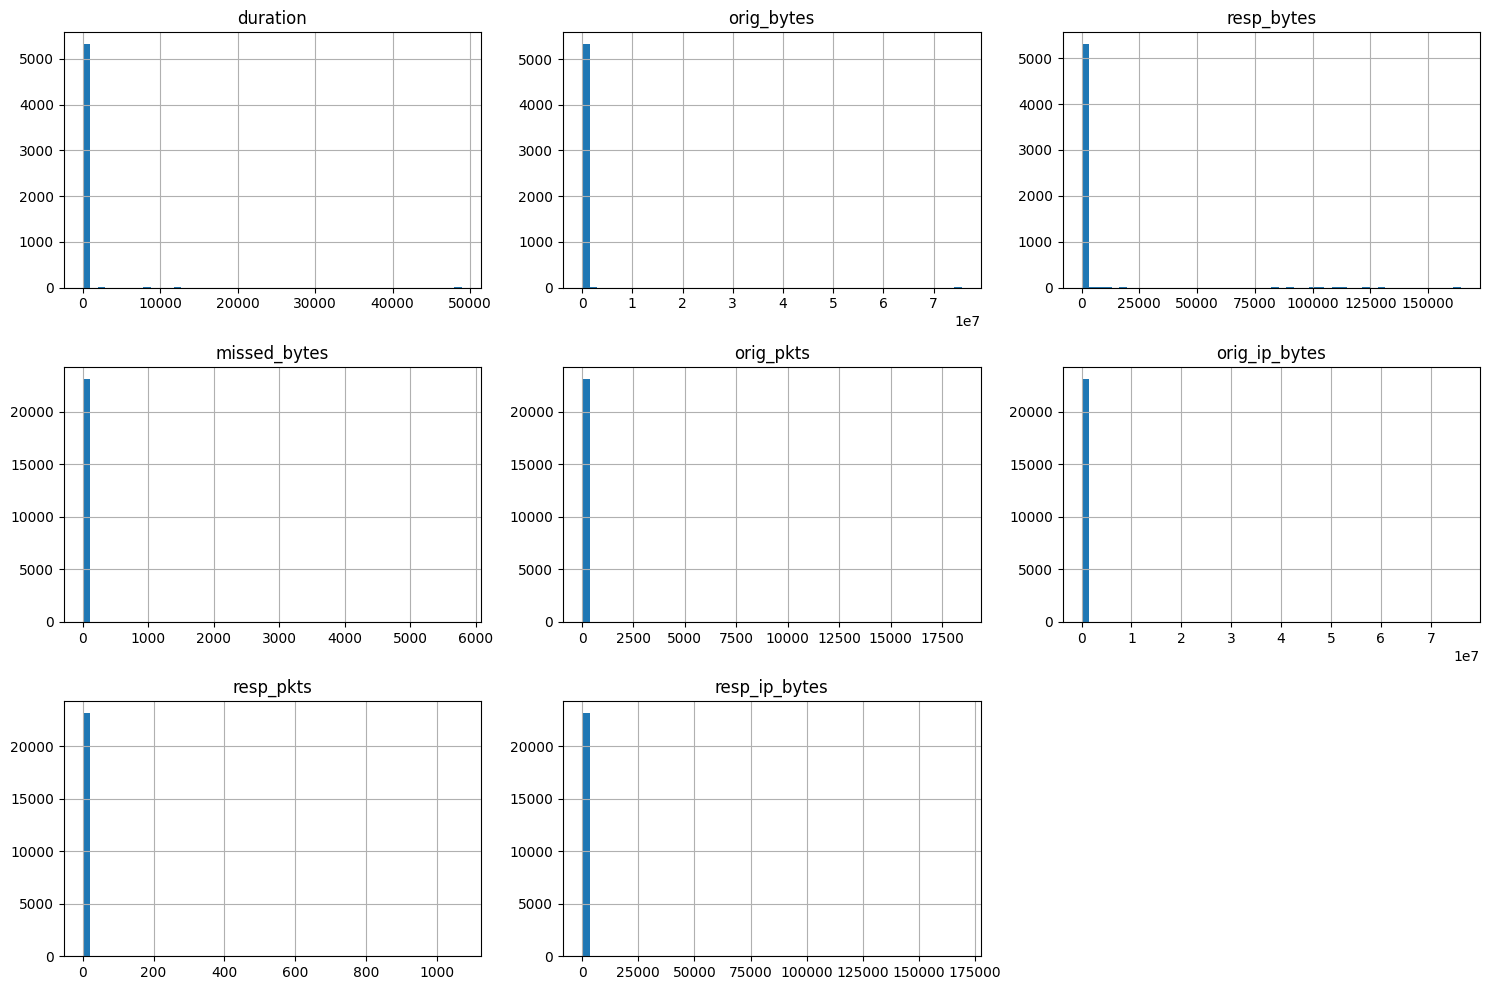

In [ ]:
# Histograma geral da distribuição de cada valor
df[colunas_describe].hist(figsize=(15, 10), bins=50)
plt.tight_layout()
plt.show()

Aqui conseguimos verificar que o gráfico acima tem sua distribuição concentranda em torno de 0, o que já era esperado conforme os describe que olhamos acima.

Para uma compreensão melhor vamos realizar uma visualização das categorias mais vistas nas colunas categoricas. Como a porta de origem e a de destino, etc.

In [ ]:
# Verificando os valores nas tabelas categoricas _> Transformar em um DF para colocar no trabalho
colunas_cat = [
    'label', 'history', 'conn_state',
    'service', 'proto', 'id.resp_h',
    'id.orig_h'
]

for col in colunas_cat:
  print("===" * 20, f"{col}", "===" * 20)
  display(obter_tab_freq(df, col))
  print("\n")

============================================================ label ============================================================


,label,freq_absoluta,freq_relativa
0,Malicious DDoS,14394,62.190000
1,Malicious C&C,6706,28.970000
2,Benign,1923,8.310000
3,Malicious PartOfAHorizontalPortScan,122,0.530000




============================================================ history ============================================================


,history,freq_absoluta,freq_relativa
0,C,14252,61.580000
1,S,5417,23.400000
2,ShAdDaf,1477,6.380000
3,D,978,4.230000
4,Dd,836,3.610000
5,ShAdDaft,102,0.440000
6,ShAdfDr,48,0.210000
7,CCCC,6,0.030000
8,ShADadttcfF,3,0.010000
9,ShADadtcfF,3,0.010000




============================================================ conn_state ============================================================


,conn_state,freq_absoluta,freq_relativa
0,OTH,14260,61.610000
1,S0,6395,27.630000
2,S3,1584,6.840000
3,SF,849,3.670000
4,RSTR,53,0.230000
5,S1,4,0.020000




============================================================ service ============================================================


,service,freq_absoluta,freq_relativa
0,irc,1641,7.090000
1,dns,192,0.830000
2,http,12,0.050000
3,dhcp,2,0.010000




============================================================ proto ============================================================


,proto,freq_absoluta,freq_relativa
0,tcp,21331,92.160000
1,udp,1814,7.840000




============================================================ id.resp_h ============================================================


,id.resp_h,freq_absoluta,freq_relativa
0,123.59.209.185,14260,61.610000
1,185.244.25.235,6771,29.250000
2,147.231.100.5,775,3.350000
3,192.168.1.1,194,0.840000
4,195.113.144.201,160,0.690000
5,82.113.53.40,154,0.670000
6,77.78.107.252,136,0.590000
7,71.61.66.148,133,0.570000
8,66.67.61.168,121,0.520000
9,81.2.248.189,119,0.510000




============================================================ id.orig_h ============================================================


,id.orig_h,freq_absoluta,freq_relativa
0,192.168.1.195,23144,100.000000
1,192.168.1.1,1,0.000000


Aqui vamos criar uma coluna de classe que vai ser baseado na coluna `label`, na qual essa coluna vai ser usada para verificar correlações entre as colunas numéricas.

Outro ponto interessante de notar que só temos um Ip de origem, no caso ele foi responsavél por tentar se conectar a milhares de destinos diferente, sendo assim uma varredura da rede.

In [ ]:
df['class'] = df['label'].apply(lambda x: 0 if x == 'Benign' else 1)
df

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,class
0,1545403816.962094,CrDn63WjJEmrWGjqf,192.168.1.195,41040,185.244.25.235,80,tcp,NaN,3.139211,0.000000,0.000000,S0,0,S,3,180,0,0,Benign,0
1,1545403824.181240,CY9lJW3gh1Eje4usP6,192.168.1.195,41040,185.244.25.235,80,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,Benign,0
2,1545403832.341331,CcFXLynukEDnUlvgl,192.168.1.195,41040,185.244.25.235,80,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,Benign,0
3,1545403848.981338,CDrkrSobGYxHhYfth,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149.000000,128252.000000,SF,2896,ShADadttcfF,94,5525,96,139044,Benign,0
4,1545403850.554283,CTWZQf2oJSvq6zmPAc,192.168.1.195,41042,185.244.25.235,80,tcp,NaN,3.147116,0.000000,0.000000,S0,0,S,3,180,0,0,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,1545490133.961380,C2F17zSUnGOcWzBa7,192.168.1.195,57110,185.244.25.235,6667,tcp,irc,32.840994,62.000000,269.000000,S3,0,ShAdDaf,7,434,6,589,Malicious C&C,1
23141,1545489934.221598,C93P4z4k5IRJD1rXJg,192.168.1.195,57092,185.244.25.235,6667,tcp,irc,36.290833,62.000000,260.000000,S3,0,ShAdDaf,10,606,7,632,Malicious C&C,1
23142,1545490198.463564,CXLZ3A2QY5E8weqpDk,192.168.1.195,123,147.251.48.140,123,udp,NaN,NaN,NaN,NaN,S0,0,D,1,76,0,0,Benign,0
23143,1545490181.542213,CuXpFN3fWesWBXUhq1,192.168.1.195,123,82.113.53.40,123,udp,NaN,NaN,NaN,NaN,S0,0,D,1,76,0,0,Benign,0


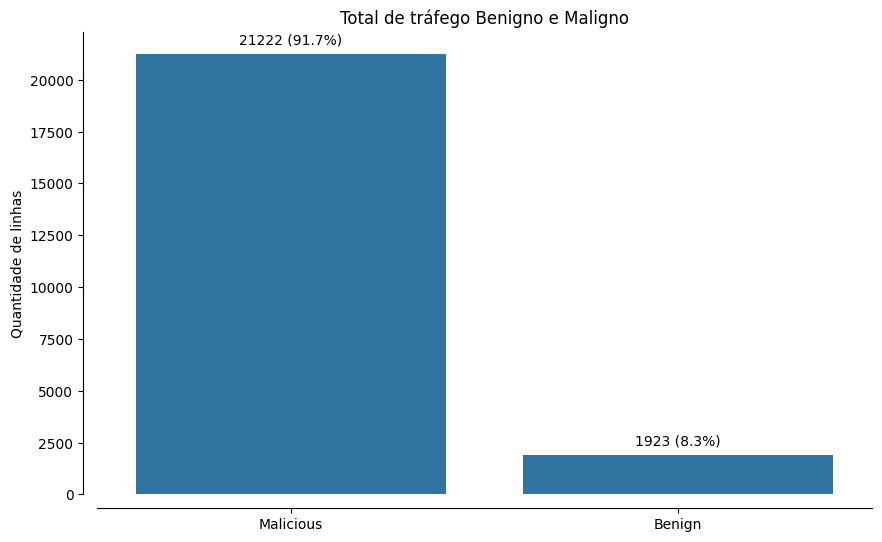

In [ ]:
df['class_name'] = df['class'].map({0: 'Benign', 1: 'Malicious'})

df_barplot = df['class_name'].value_counts().to_frame().reset_index()

barplot(
    df_barplot,
    x='class_name',
    y='count',
    ylab="Quantidade de linhas",
    title="Total de tráfego Benigno e Maligno",
    order_desc=True,
    figsize=(10, 6)
)

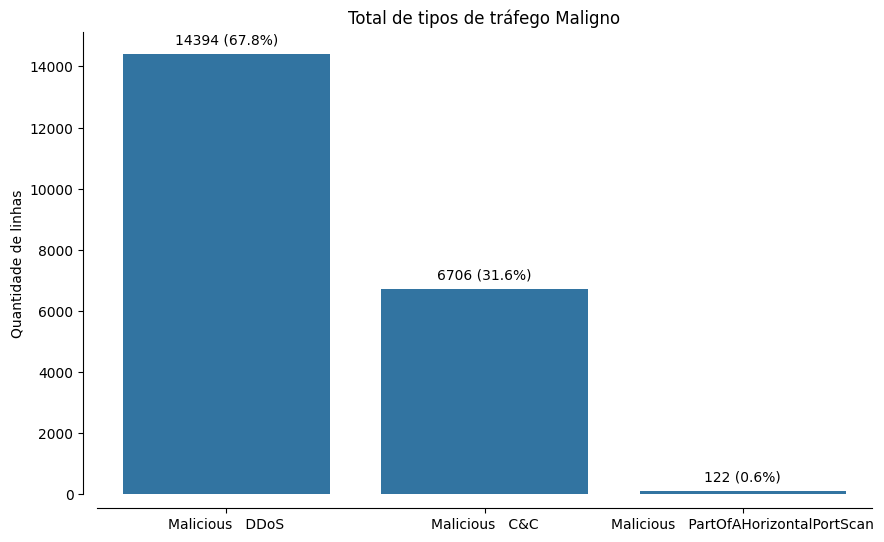

In [ ]:
df_barplot = df[df['class'] == 1]['label'].value_counts().to_frame().reset_index()

barplot(
    df_barplot,
    x='label',
    y='count',
    ylab="Quantidade de linhas",
    title="Total de tipos de tráfego Maligno",
    order_desc=True,
    figsize=(10, 6)
)

## 5. Análises Exploratórias

Nesta seção vamos aplicar as nossas análises a fim de tirar insights e entender os nossos dados.

### 5.1 Qual o comporatmento da distribuição das colunas que não são maliciosas?

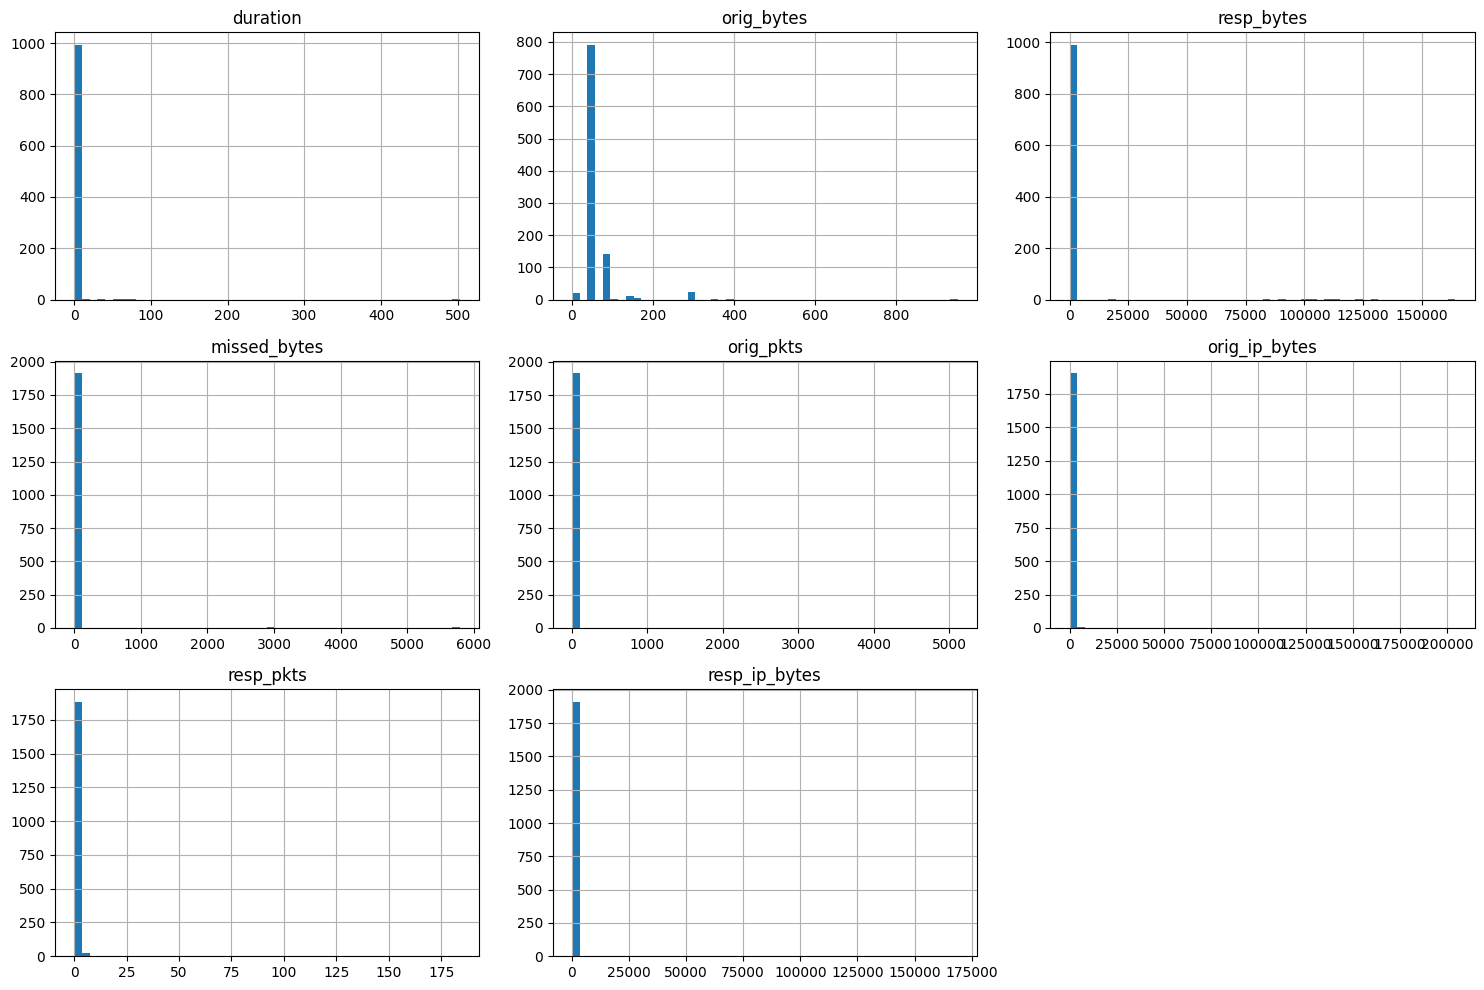

In [ ]:
df[df['class'] == 0][colunas_describe].hist(figsize=(15, 10), bins=50)
plt.tight_layout()
plt.show()

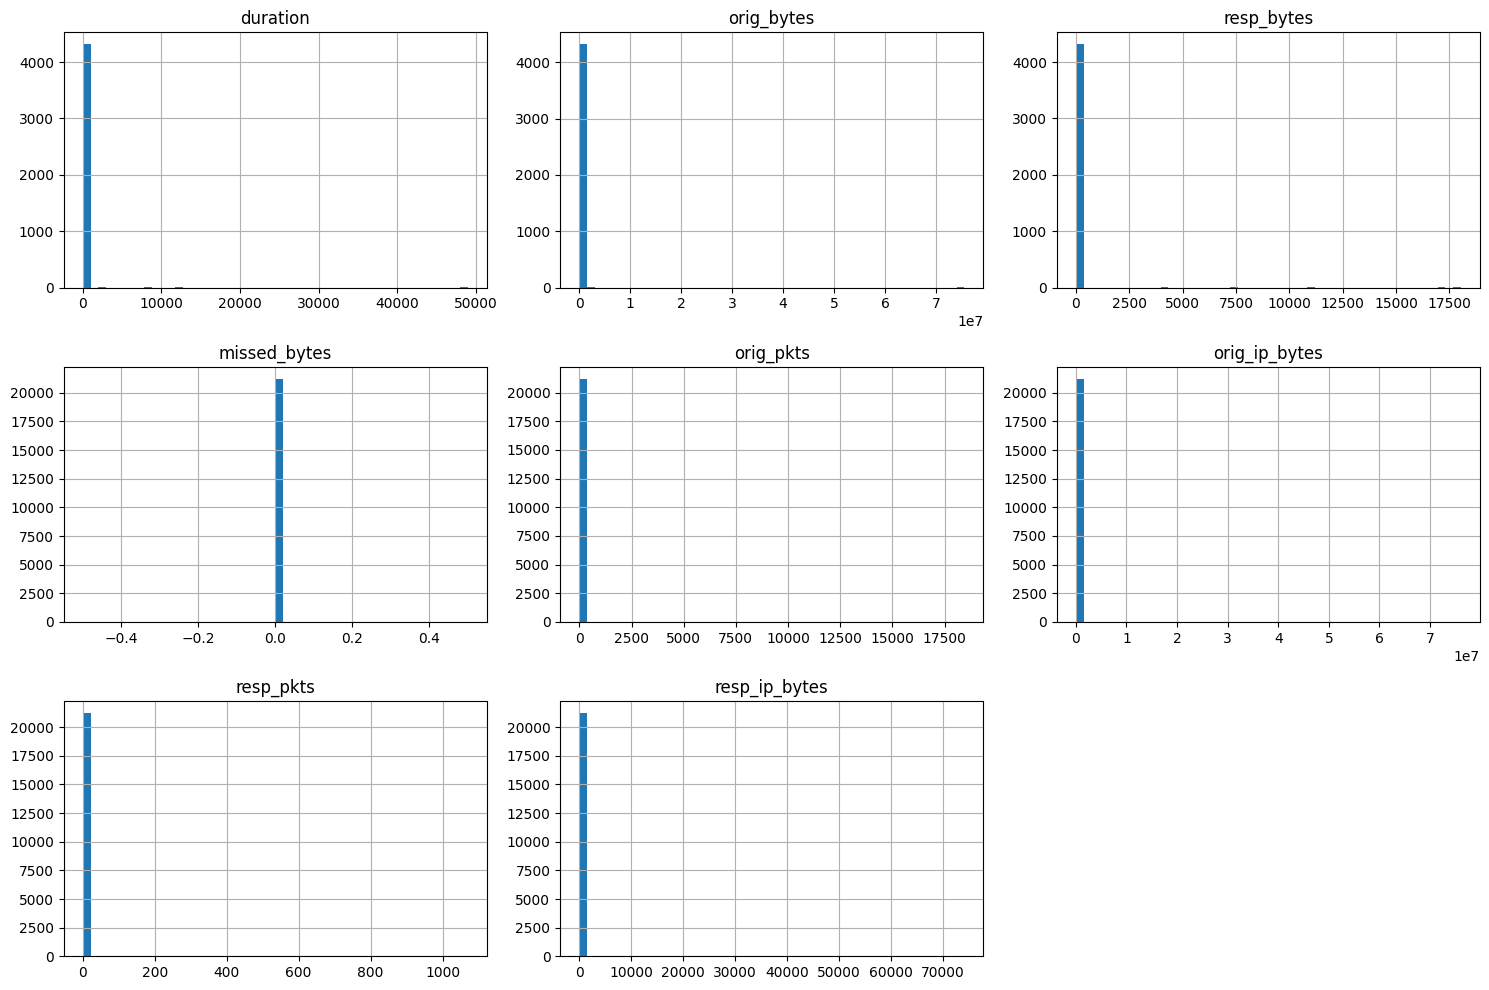

In [ ]:
df[df['class'] == 1][colunas_describe].hist(figsize=(15, 10), bins=50)
plt.tight_layout()
plt.show()

Verificando apenas a distribuição não se encontra nada revelador sobre ser malicioso ou não.

**VALIDAR ANÁLISE**

### 5.2 Quando olhamos os tráfego malicioso quais são as portas mais visadas?

In [ ]:
df_mal = df[df['class'] == 1]
df_mal['service'].value_counts() # Só temos um serviço mapeado e os demais são nulos

,count
service,
irc,1641


In [ ]:
df[df['class'] == 0]['service'].value_counts()

,count
service,
dns,192
http,12
dhcp,2


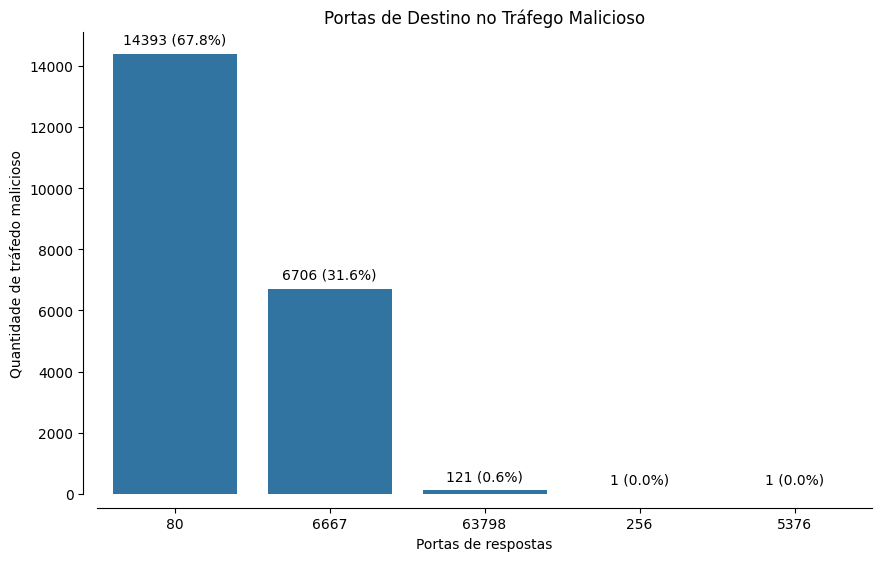

In [ ]:
df_count = df_mal['id.resp_p'].value_counts().reset_index()
barplot(
    df_count,
    x='id.resp_p',
    y='count',
    xlab="Portas de respostas",
    ylab="Quantidade de tráfedo malicioso",
    title="Portas de Destino no Tráfego Malicioso",
    order_desc=True,
    figsize=(10, 6)
)

Aqui conseguimos notar que a porta 80 é a que mais contém tráfegos maliciosos, seguido da 6667 que juntas são responsaveis por mais de 95% dos casos.

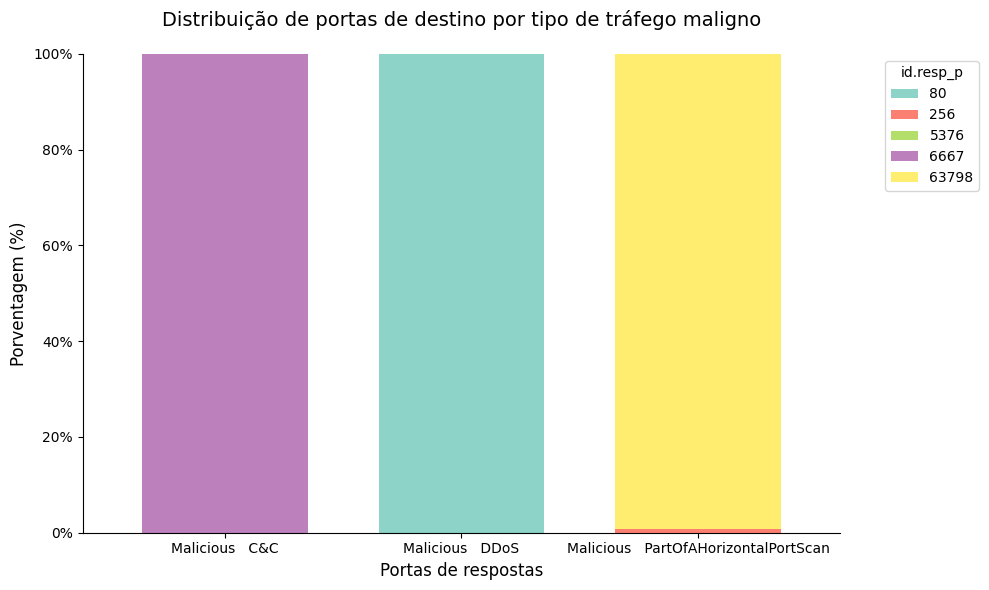

In [ ]:
plot_stacked_bar_100(
    df=df_mal,
    coluna_1='label',
    coluna_2='id.resp_p',
    xlab="Portas de respostas",
    ylab="Porventagem (%)",
    title="Distribuição de portas de destino por tipo de tráfego maligno"
);

In [ ]:
crosstab = pd.crosstab(df['label'], df['id.resp_p'])
crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
crosstab_pct

id.resp_p,1,22,53,67,80,123,256,5376,6667,63798
label,,,,,,,,,,
Benign,0.208008,0.052002,12.116485,0.104004,3.380135,84.139366,0.000000,0.000000,0.000000,0.000000
Malicious C&C,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000
Malicious DDoS,0.000000,0.000000,0.000000,0.000000,99.993053,0.000000,0.000000,0.006947,0.000000,0.000000
Malicious PartOfAHorizontalPortScan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.819672,0.000000,0.000000,99.180328


**VALIDAR ANÁLISE**

### 5.3 Caracterização do fracasso do ataque, análise do estado da conexão

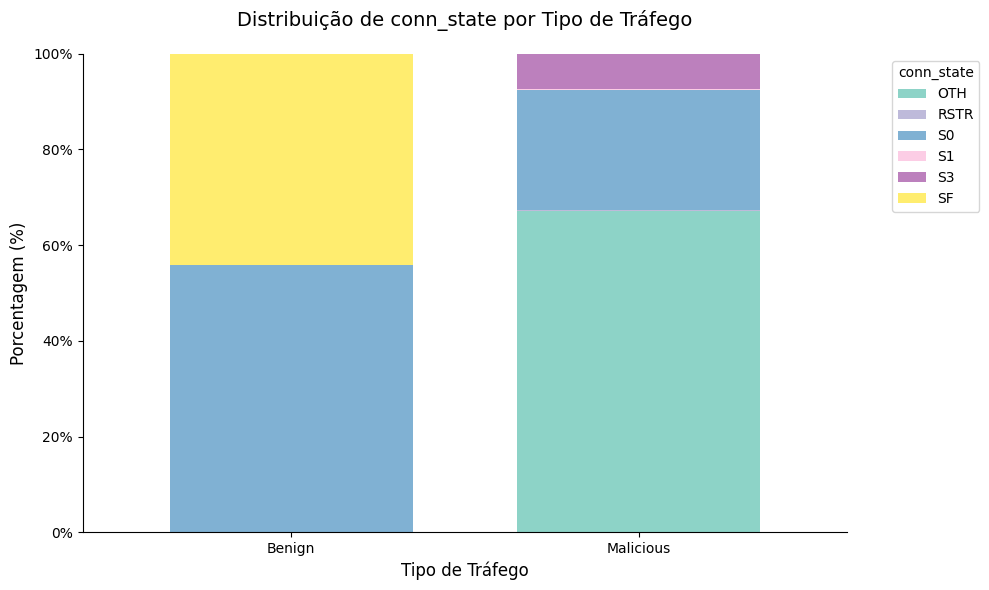

In [ ]:
plot_stacked_bar_100(
    df,
    coluna_1='class_name',
    coluna_2='conn_state',
    xlab="Tipo de Tráfego",
    ylab="Porcentagem (%)",
    title="Distribuição de conn_state por Tipo de Tráfego"
)

plt.show()

In [ ]:
df_plot = df.copy()
df_plot['class_label'] = df_plot['class'].map({0: 'Benign', 1: 'Malicious'})

crosstab = pd.crosstab(df_plot['class_label'], df_plot['conn_state'])
crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
crosstab_pct

conn_state,OTH,RSTR,S0,S1,S3,SF
class_label,,,,,,
Benign,0.000000,0.000000,55.850234,0.000000,0.000000,44.149766
Malicious,67.194421,0.249741,25.073037,0.018848,7.463953,0.000000


Aqui podemos ver que nosso tráfego benigno é composto em sua grande parte por **SF** e **S0**. Enquanto nosso malicioso tem em sua maioria **OTH**, **S0** e **S3**.

**VALIDAR ANÁLISE**

### 5.4 Quando olhamos os protocolos, quais são a distribuição do tráfegos neles?

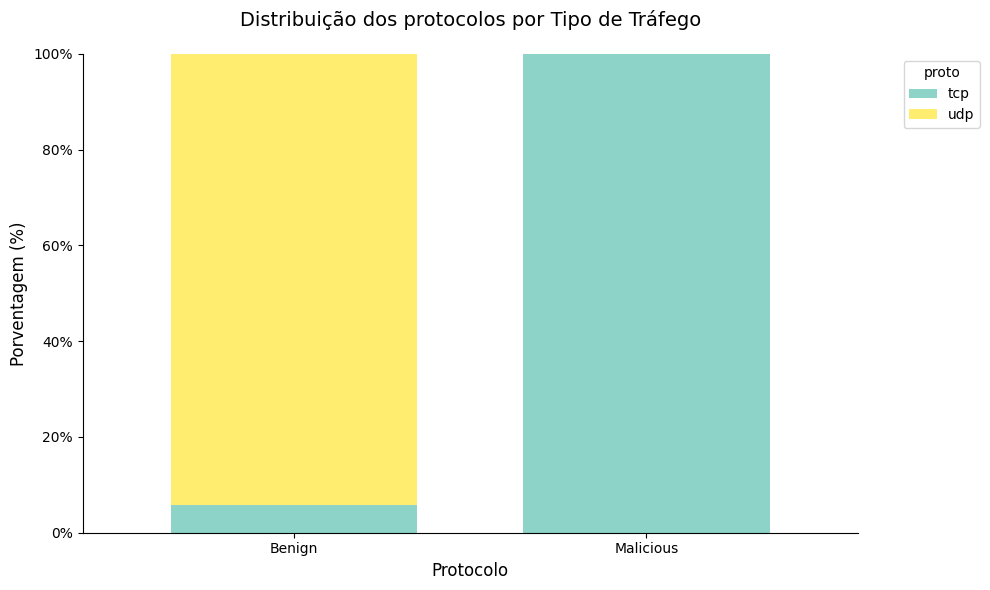

In [ ]:
plot_stacked_bar_100(
    df,
    coluna_1='class_name',
    coluna_2='proto',
    xlab="Protocolo",
    ylab="Porventagem (%)",
    title="Distribuição dos protocolos por Tipo de Tráfego"
)

plt.show()

### 5.5 Volume de Dados

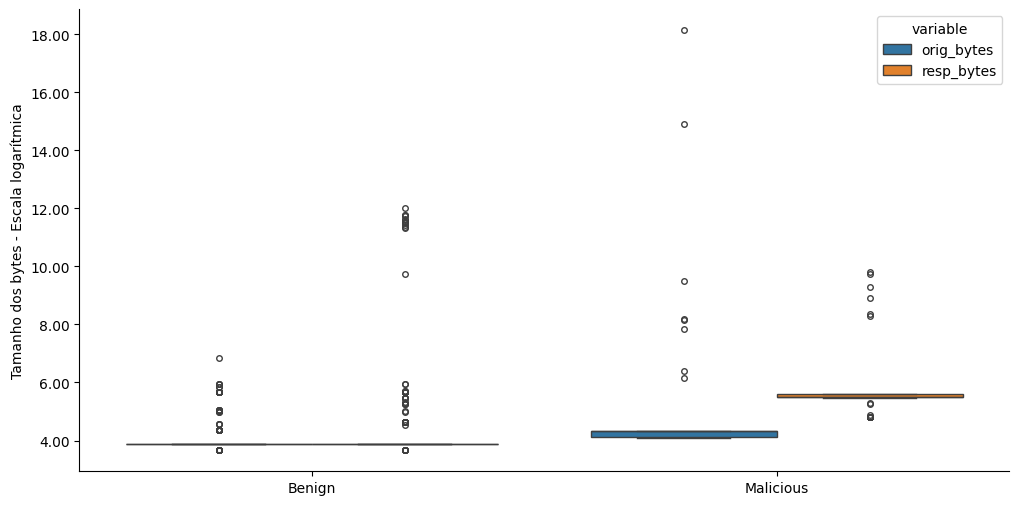

In [ ]:
df_melt = pd.melt(df, id_vars=['class_name'], value_vars=['orig_bytes', 'resp_bytes'])
df_melt['value_log'] = np.log(df_melt['value'])

box_plot(
    df_melt,
    x='class_name',
    y='value_log',
    hue='variable',
    xlab='',
    ylab='Tamanho dos bytes - Escala logarítmica',
)

In [ ]:
# df[df['class'] == 0]['resp_bytes'].median()

In [ ]:
df_melt[df_melt['variable'] == 'orig_bytes'].groupby('class_name')['value'].median()

,value
class_name,
Benign,48.000000
Malicious,0.000000


In [ ]:
df_melt[df_melt['variable'] == 'resp_bytes'].groupby('class_name')['value'].median()

,value
class_name,
Benign,48.000000
Malicious,0.000000


**VALIDAR ANÁLISE**

Resultado não está como o esperado.

Uma análises interessante de se aplicar aqui é verificar se o cabeçalho de origem para do tráfego maligno é maior que o do tráfego maligno. Inchar o cabeçalho é uma forma de prejudicar o servuço principalmente em ataques DDoS, assim como deixar campos opcionais para extrair dados. Então um cabeçalho maior pode indicar algo.

In [ ]:
# Verificando a média
df['header_size'] = df['orig_ip_bytes'] - df['orig_bytes']

header_size_malig = df[df['class'] == 1]['header_size'].mean()
header_size_benig = df[df['class'] == 0]['header_size'].mean()

header_size_malig, header_size_benig

(np.float64(1141.621815655396), np.float64(965.7068793619143))

In [ ]:
# Verificando a média
df['header_size'] = df['orig_ip_bytes'] - df['orig_bytes']

header_size_malig = df[df['class'] == 1]['header_size'].median()
header_size_benig = df[df['class'] == 0]['header_size'].median()

header_size_malig, header_size_benig

(180.0, 28.0)

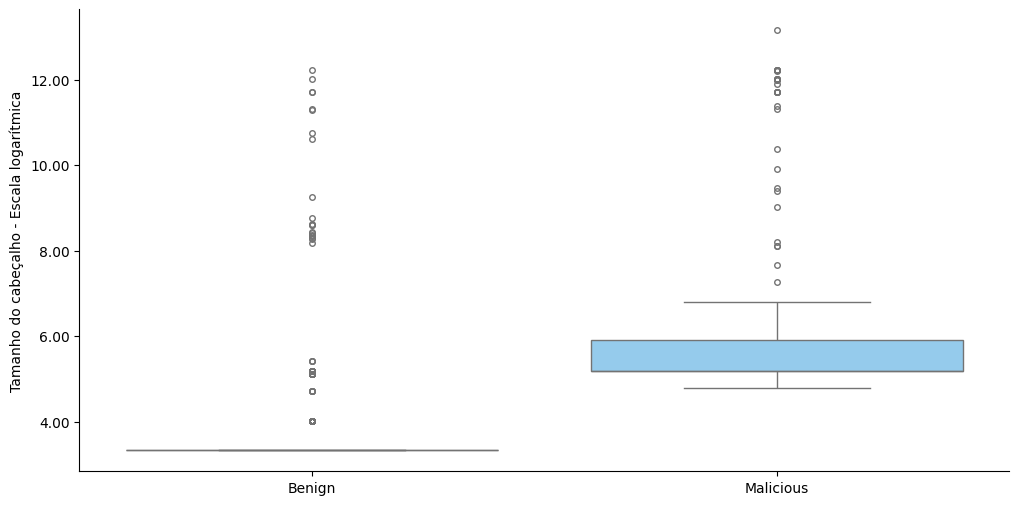

In [ ]:
df_melt = pd.melt(df, id_vars=['class_name'], value_vars=['header_size'])
df_melt['value_log'] = np.log(df_melt['value'])

box_plot(
    df_melt,
    x='class_name',
    y='value_log',
    xlab='',
    ylab='Tamanho do cabeçalho - Escala logarítmica',
)

Aqui conseguimos ver que tanto a média quanto a mediana são maiores o que confirma a suspeita do tamanho do cabeçalho como algo a ser analisado em ataques.

### 5.6 Análise de pacotes por conexão

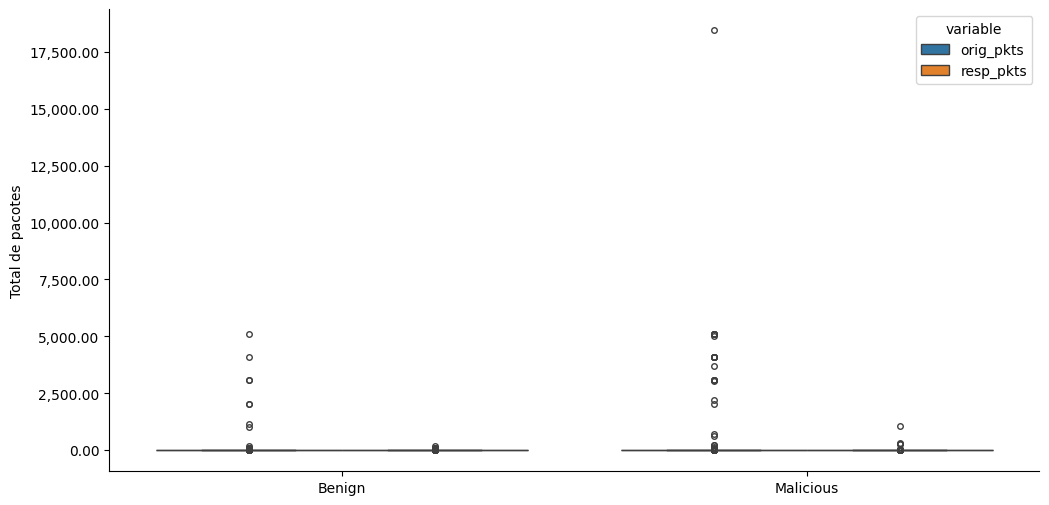

In [ ]:
df_melt = pd.melt(df, id_vars=['class_name'], value_vars=['orig_pkts', 'resp_pkts'])
df_melt['value_log'] = np.log(df_melt['value'])

box_plot(
    df_melt,
    x='class_name',
    y='value',
    hue='variable',
    xlab='',
    ylab='Total de pacotes',
)

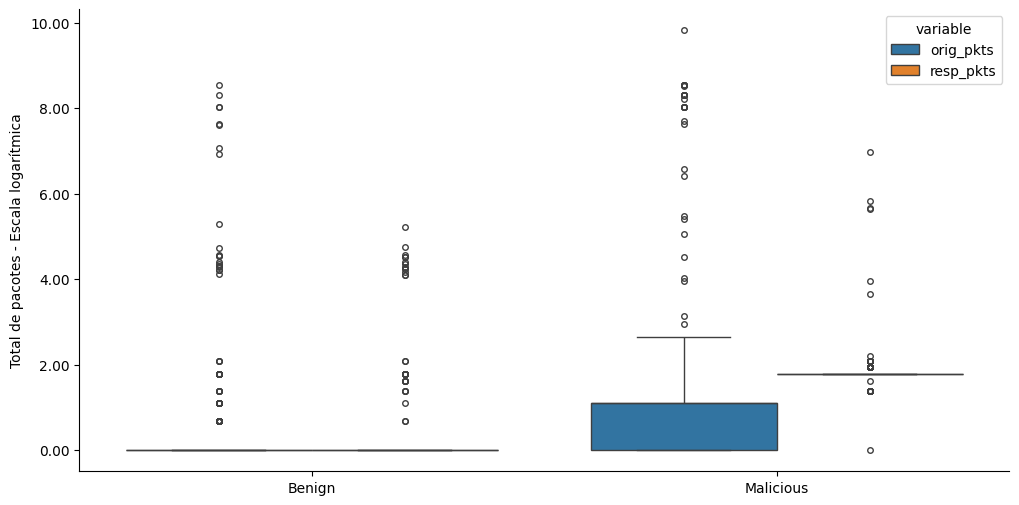

In [ ]:
box_plot(
    df_melt,
    x='class_name',
    y='value_log',
    hue='variable',
    xlab='',
    ylab='Total de pacotes - Escala logarítmica',
)

In [ ]:
df_melt[df_melt['variable'] == 'orig_pkts'].groupby('class_name')['value'].median()

,value
class_name,
Benign,1.000000
Malicious,0.000000


In [ ]:
df_melt[df_melt['variable'] == 'resp_pkts'].groupby('class_name')['value'].median()

,value
class_name,
Benign,0.000000
Malicious,0.000000


### 5.7 Análise temporal

In [ ]:
df_st = df.copy()

df_st['ts'] = pd.to_datetime(df['ts'], unit='s')
df_st = df_st.set_index('ts')

In [ ]:
connections_per_minute = df_st.resample('T').size()

fig = px.line(x=connections_per_minute.index,
              y=connections_per_minute.values,
              title='Volume Total de Conexões por Minuto',
              labels={'x': 'Tempo', 'y': 'Número de Conexões'})

fig.update_traces(line_color='navy')
fig.show()

In [ ]:
traffic_by_class_per_minute = df_st.groupby('class_name').resample('T').size().unstack(level=0)

fig = px.line(traffic_by_class_per_minute,
              title='Tráfego Malicioso vs. Benigno por Minuto',
              labels={'index': 'Tempo', 'value': 'Número de Conexões'},
              color_discrete_sequence=['green', 'red'])

fig.update_layout(legend_title_text='Tipo de Tráfego')
fig.show()

In [ ]:
bytes_per_minute = df_st['orig_bytes'].fillna(0).resample('T').sum()

# Converter para MB para facilitar a leitura
bytes_per_minute_mb = bytes_per_minute / 1e6

fig = px.line(x=bytes_per_minute_mb.index,
              y=bytes_per_minute_mb.values,
              title='Volume de Bytes de Origem por Minuto',
              labels={'x': 'Tempo', 'y': 'Total de Bytes (MB)'})

fig.update_traces(line_color='purple')
fig.show()

In [ ]:
df_malicious = df_st[df_st['label'].str.contains('Malicious', na=False)].copy()

# 2. Limpar os nomes dos labels para a legenda do gráfico ficar melhor
df_malicious['attack_type'] = df_malicious['label'].str.replace('Malicious   ', '').str.replace('PartOfAHorizontalPortScan', 'PortScan')

# 3. Agrupar por minuto e por tipo de ataque, contar e reformatar
# O .unstack() é importante para transformar os tipos de ataque em colunas separadas
attack_composition = df_malicious.groupby('attack_type').resample('T').size().unstack(level=0).fillna(0)

# 4. Gerar o gráfico de área empilhada
fig = px.area(attack_composition,
              title='Composição do Tráfego Malicioso ao Longo do Tempo',
              labels={'index': 'Tempo', 'value': 'Número de Conexões por Minuto'})

fig.update_layout(legend_title_text='Tipo de Ataque')
fig.show()

### 5.8 Análise de correlação entre as variáveis numéricas

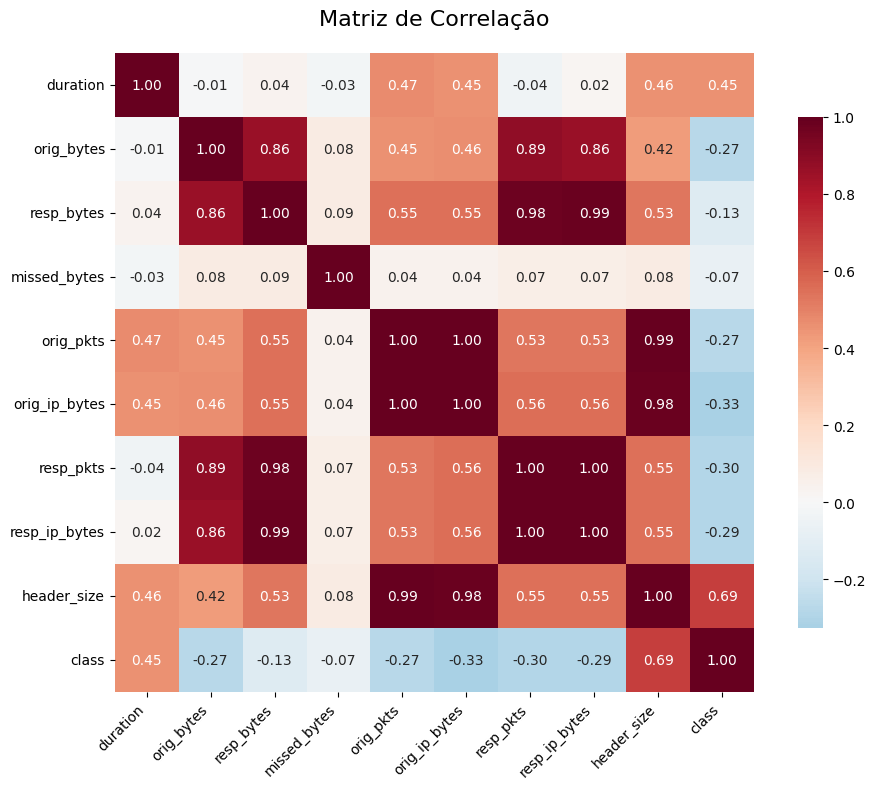

In [ ]:
colunas_corr = [
    'duration', 'orig_bytes',
    'resp_bytes', 'missed_bytes',
    'orig_pkts', 'orig_ip_bytes',
    'resp_pkts', 'resp_ip_bytes',
    'header_size', 'class'
]

correlation_matrix = df[colunas_corr].corr(method='spearman')

plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='RdBu_r',
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={'shrink': 0.8},
    annot_kws={'size': 10}
)

plt.title('Matriz de Correlação', fontsize=16, pad=20)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show();

Em relação a nossa variável alvo a gente não consegue capturar nenhuma correlação forte. O que mostra que não se tem uma relação linear entre essas variáveis. Entretanto, certas relações entre os dados se apresentam de forma bem interessnte como dados bytes perdidos e e respostas IP dos bytes.

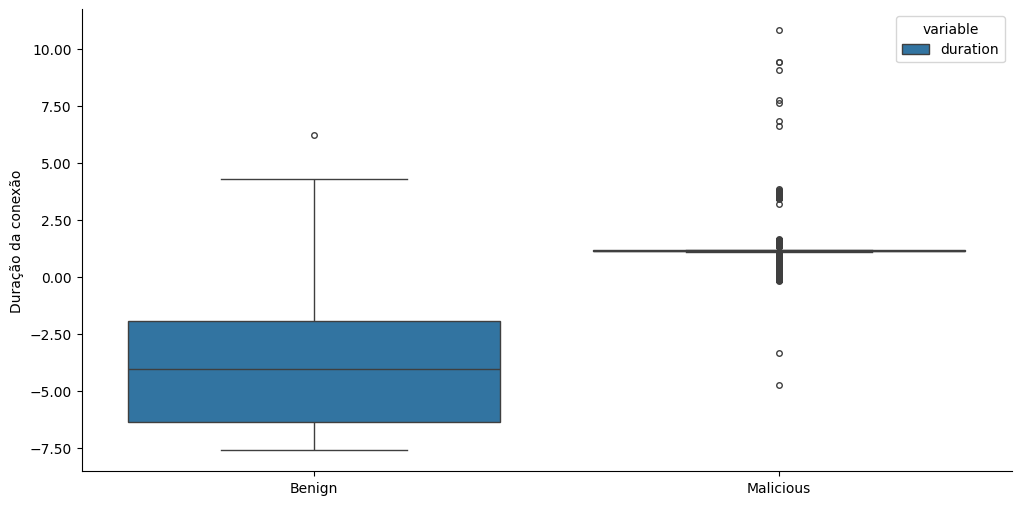

In [ ]:
df_melt = pd.melt(df, id_vars=['class_name'], value_vars=['duration'])
df_melt['value_log'] = np.log(df_melt['value'])

box_plot(
    df_melt,
    x='class_name',
    y='value_log',
    hue='variable',
    xlab='',
    ylab='Duração da conexão',
)

In [ ]:
display(df_melt[df_melt['class_name'] == 'Benign']['value'].median())
display(df_melt[df_melt['class_name'] == 'Malicious']['value'].median())

display(df_melt[df_melt['class_name'] == 'Benign']['value'].mean())
display(df_melt[df_melt['class_name'] == 'Malicious']['value'].mean())

0.017488

3.120962

np.float64(1.9368060598205386)

np.float64(27.65418802547476)

### 5.9 Análise de correlação entre as variáveis categóricas

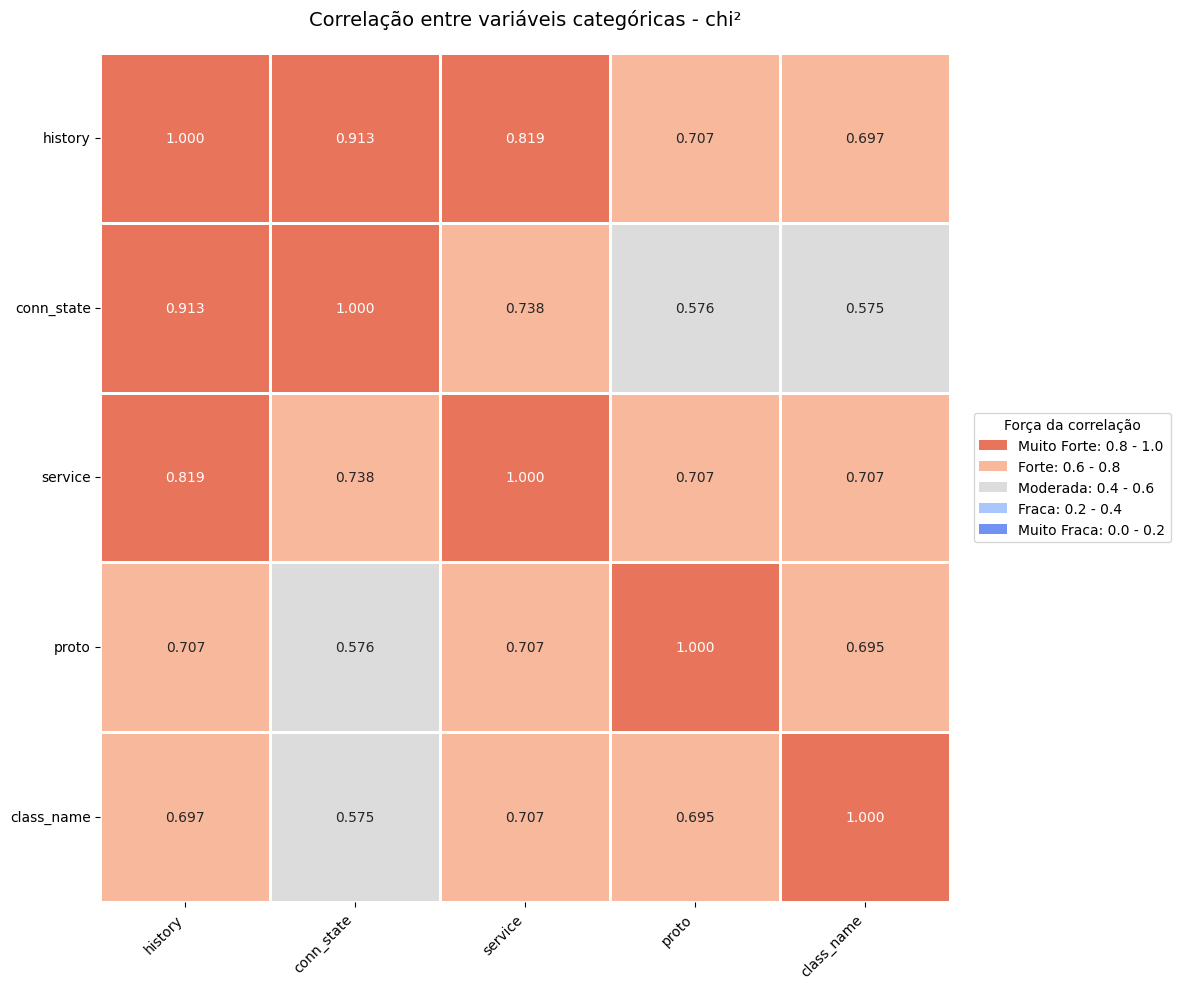

,history,conn_state,service,proto,class_name
history,1.000000,0.912871,0.818881,0.707107,0.696903
conn_state,0.912871,1.000000,0.737892,0.576122,0.574710
service,0.818881,0.737892,1.000000,0.707107,0.707107
proto,0.707107,0.576122,0.707107,1.000000,0.695259
class_name,0.696903,0.574710,0.707107,0.695259,1.000000


In [ ]:
colunas_chi =[
    'history', 'conn_state',
    'service', 'proto',
    'class_name'
]

plot_chi2_heatmap(df[colunas_chi], title="Correlação entre variáveis categóricas - chi²")

In [ ]:
df[df['class'] == 1]['history'].unique()

array(['S', 'ShAdDaf', 'ShAdDaft', 'ShAdfDr', 'ShAfdtDr', 'ShAdDatf',
       'ShAdDatfr', 'D', 'ShDadAf', 'ShAdD', 'ShADadf', 'ShAdDfr', 'ShAD',
       'C', 'CCCC', 'CCC', 'ShADad', 'ShAdDa'], dtype=object)

In [ ]:
df[df['class'] == 0]['history'].unique()

array(['S', 'ShADadttcfF', 'ShADadtcfF', 'Dd', 'D', 'ShADadtctfF',
       'DdAtaFf', 'ShADacdtfF', 'ShADadtctfFR', 'ShADadttfF'],
      dtype=object)